In [58]:
# Downloaded libraries
from matplotlib import pyplot as plt
import numpy as np
import pynwb

# Own libraries
import main


In [59]:
from scipy.ndimage import filters
def figsmooth(A,sig):
    '''apply Gaussian smoothing to matrix A containing nans with kernel sig
    without propogating nans'''

    # find zero indices to weight the smoothing matrix
    zero_inds = np.where(A == 0)

    # inversely weight zero indices
    One = np.ones(A.shape)
    One[zero_inds] = .001
    A = filters.gaussian_filter(A,sig)
    One = filters.gaussian_filter(One,sig)
    return A/One

In [63]:
fname1 = "sub-F1_ses-20190407T210000_behavior+ophys_small.nwb"
fname2 = "sub-F1_ses-20190416T210000_behavior+ophys_small.nwb"
fname3 = "sub-R1_ses-20190211T210000_behavior+ophys_small.nwb"
fname4 = "sub-R1_ses-20190223T210000_behavior+ophys_small.nwb"
fname5 = "sub-R2_ses-20190219T210000_behavior+ophys_small.nwb"
directory = "data\TestPlitt"

R1LateFiles = ["sub-R1_ses-20190220T210000_behavior+ophys_small.nwb",\
               "sub-R1_ses-20190221T210000_behavior+ophys_small.nwb",\
               "sub-R1_ses-20190222T210000_behavior+ophys_small.nwb",\
               "sub-R1_ses-20190223T210000_behavior+ophys_small.nwb"]

F1early = main.getSessionHandle(fname1, directory)
F1late = main.getSessionHandle(fname2, directory)
R1early = main.getSessionHandle(fname3, directory)
R1late = main.getSessionHandle(fname4, directory)
R2 = main.getSessionHandle(fname5, directory)

In [98]:
nNeurons = {}
deconvTraces = {}
startIndices = {}
baseMorph = {}
position = {}

readFiles = [main.getSessionHandle(file, directory) for file in R1LateFiles]
nFiles = len(readFiles)

for i, file in enumerate(readFiles):
    data = main.dataExtraction(readFiles[i].read())

    # nFrames = data["nFrames"]
    nNeurons[i] = data["nNeurons"]
    deconvTraces[i] = data["deconvTraces"]
    # tstartData = data["tstartData"]
    # nTrials = data["nTrials"]
    startIndices[i] = data["startIndices"]
    baseMorph[i] = data["baseMorph"]
    # totalMorph = data["totalMorph"]
    position[i] = data["position"]

In [99]:
df = {}
occp = {}

for i in range(nFiles):
    dbs, pbs = main.trialize(deconvTraces[i], position[i], startIndices[i])
    df[i], occp[i] = main.positionalBin(dbs, pbs)

In [101]:
SIMatrix = {i:np.zeros((nNeurons[i], 5)) for i in range(nFiles)}
baseMorphList = {i:baseMorph[i][startIndices[i]] for i in range(nFiles)} 
 
for sess in range(nFiles):
    for i in range(nNeurons[sess]):
        SIMatrix[sess][i,:] = main.getSpatialInformation(df[sess][:,:,i], occp[sess], baseMorphList[sess])
       

In [111]:
thresholds = {i:np.percentile(SIMatrix[i], 93) for i in range(nFiles)}
# print(thresholds)
placeCellInds = {sess:{} for sess in range(nFiles)}
for sess in range(nFiles):
    for i, key in enumerate(main.baseMorphValues):
        placeCellInds[sess][key] = np.where(SIMatrix[sess][:,i] > thresholds[sess])[0]
        

In [120]:
df_placeCells = {}
baseIndices = {}
avgActivity = {}

for sess in range(nFiles):
    # extracts the sub-dataframes for the place cells for each basemorph value (all trials)
    df_placeCells[sess] = {key:df[sess][:,:,placeCellInds[sess][key]] for key in main.baseMorphValues}

    # gets the indices of the trials at each base morph value
    baseIndices[sess] = {i:np.where(baseMorphList[sess] == i)[0] for i in main.baseMorphValues}

    avgActivity[sess] = {key:{} for key in main.baseMorphValues}
    for cells in main.baseMorphValues:
        for trials in main.baseMorphValues:
            bInds = baseIndices[sess][trials]
            num = np.sum(df_placeCells[sess][cells][bInds], axis = 0)
            den = np.sum(occp[sess][bInds], axis = 0).reshape(-1,1)
            avgActivity[sess][cells][trials] = num / den


In [126]:
avgActMat = {sess:np.empty((5,), dtype=object) for sess in range(nFiles)}
norms = {}

for sess in range(nFiles):
    for i, row in enumerate(main.baseMorphValues):
        for j, col in enumerate(main.baseMorphValues):
            if j == 0:
                avgActMat[sess][i] = avgActivity[sess][row][col]
            else:
                avgActMat[sess][i] = np.vstack((avgActMat[sess][i], avgActivity[sess][row][col]))

    norms[sess] = [np.max(mat, axis=0) for mat in avgActMat[sess]]



(143,)


### Calculation of place cell metrics

##### Testing area

In [135]:
allPlaceCellsNum = {}
placeCellNum = {}
placeCellPct = {}

for sess in range(nFiles):
    print(f"\nFor session {sess}:")
    allPlaceCellsNum[sess] = len(np.unique(np.where(SIMatrix[sess] > threshold)[0]))
    print("The total number of ROIs that are place cells for at least one base morph is:", allPlaceCellsNum[sess], "out of", nNeurons[sess], "cells")

    placeCellNum[sess] = {inds:len(placeCellInds[sess][inds]) for inds in placeCellInds[sess]}
    placeCellPct[sess] = {inds:len(placeCellInds[sess][inds])*100/nNeurons[sess] for inds in placeCellInds[sess]}

    for base in main.baseMorphValues:
        print(f"For base morph {base}:\t {placeCellNum[sess][base]} place cells, \t {placeCellPct[sess][base]:.2f}% of all ROIs")
    
# print(placeCellNum)
# print(placeCellPct)


For session 0:
The total number of ROIs that are place cells for at least one base morph is: 889 out of 2066 cells
For base morph 0.0:	 153 place cells, 	 7.41% of all ROIs
For base morph 0.25:	 143 place cells, 	 6.92% of all ROIs
For base morph 0.5:	 143 place cells, 	 6.92% of all ROIs
For base morph 0.75:	 153 place cells, 	 7.41% of all ROIs
For base morph 1.0:	 132 place cells, 	 6.39% of all ROIs

For session 1:
The total number of ROIs that are place cells for at least one base morph is: 507 out of 2066 cells
For base morph 0.0:	 148 place cells, 	 7.16% of all ROIs
For base morph 0.25:	 163 place cells, 	 7.89% of all ROIs
For base morph 0.5:	 169 place cells, 	 8.18% of all ROIs
For base morph 0.75:	 118 place cells, 	 5.71% of all ROIs
For base morph 1.0:	 126 place cells, 	 6.10% of all ROIs

For session 2:
The total number of ROIs that are place cells for at least one base morph is: 683 out of 2074 cells
For base morph 0.0:	 140 place cells, 	 6.75% of all ROIs
For base m

In [138]:
peaks = {}
rewardPeaks = {}

for sess in range(nFiles):
    peaks[sess] = {base:np.argmax(avgActivity[sess][base][base],axis=0) for base in main.baseMorphValues}
    rewardPeaks[sess] = {base:len(np.where((peaks[sess][base] > 25) & (peaks[sess][base] < 40))[0]) for base in main.baseMorphValues}
    # rewardPeaks = {base:len(np.where((peaks[base] > 25))[0]) for base in main.baseMorphValues}

    print(f"\nFor session {sess}:")
    for base in main.baseMorphValues:
#         print(f"For base morph {base}:\t {rewardPeaks[sess][base]} cells tuned for reward region")
        print(f"For base morph {base}:\t {100*rewardPeaks[sess][base]/placeCellNum[sess][base]:.2f} % cells tuned for reward region ({rewardPeaks[sess][base]} cells)")    


For session 0:
For base morph 0.0:	 45.10 % cells tuned for reward region (69 cells)
For base morph 0.25:	 41.96 % cells tuned for reward region (60 cells)
For base morph 0.5:	 41.96 % cells tuned for reward region (60 cells)
For base morph 0.75:	 41.18 % cells tuned for reward region (63 cells)
For base morph 1.0:	 34.09 % cells tuned for reward region (45 cells)

For session 1:
For base morph 0.0:	 45.27 % cells tuned for reward region (67 cells)
For base morph 0.25:	 43.56 % cells tuned for reward region (71 cells)
For base morph 0.5:	 43.79 % cells tuned for reward region (74 cells)
For base morph 0.75:	 35.59 % cells tuned for reward region (42 cells)
For base morph 1.0:	 33.33 % cells tuned for reward region (42 cells)

For session 2:
For base morph 0.0:	 42.86 % cells tuned for reward region (60 cells)
For base morph 0.25:	 45.95 % cells tuned for reward region (68 cells)
For base morph 0.5:	 36.88 % cells tuned for reward region (52 cells)
For base morph 0.75:	 32.74 % cells t

In [175]:
# NEEDED: aggregate average activity peaks. we will have per baseMorph, one set of peaks.
# This code aggregates the location of the activity peaks from all sessions. We are only taking the avgActivity of place cells
# in trials that match the baseMorph they are considered a place cell in.

allPeaks = {}
for base in main.baseMorphValues:
    for sess in range(nFiles):
        if sess == 0:
            allPeaks[base] = np.argmax(avgActivity[sess][base][base],axis=0)
        else:
            allPeaks[base] = np.hstack((allPeaks[base], np.argmax(avgActivity[sess][base][base],axis=0)))        
                   
    

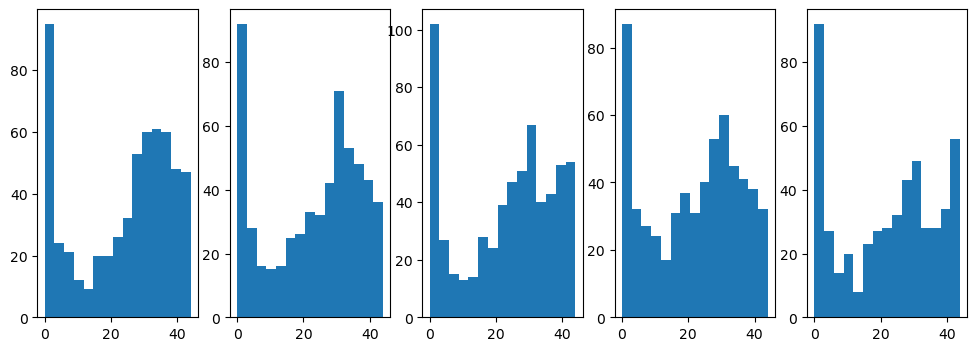

In [176]:
fig, ax = plt.subplots(1,5, figsize=(12,4))

## This section of code was for plotting the histogram of peaks corresponding to one session only
# for i, base in enumerate(main.baseMorphValues):
#     ax[i].hist(np.argmax(avgActivity[1][base][base],axis=0), bins=10)

# This handles the aggregated peaks and plots the aggregated historgram
for i, base in enumerate(main.baseMorphValues):
    ax[i].hist(allPeaks[base], bins=15)
    

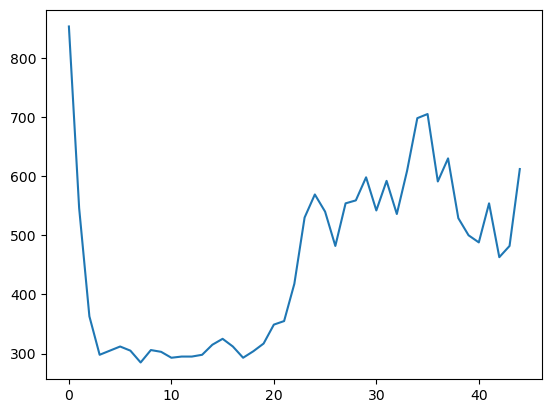

In [57]:
# np.shape(occp)
plt.plot(np.sum(occp, axis=0))

### Plotting of rose-gold plot

## Plotting for MULTIPLE SESSIONS

In [219]:
# Stack for 5x5 grid
# This code stacks the 5x5 grid of calculated average activity for each session into one aggregated 5x5 grid of average activity
# It also handles the stacking of the normalization factors calculated for each session (each session has 5, one for each baseMorph) 

allCellsToPlot = {key:{} for key in main.baseMorphValues}
allNorms = {}
for sess in range(nFiles):
    for row, cells in enumerate(main.baseMorphValues):
        if sess == 0:
            allNorms[row] = norms[sess][row]
        else:
            allNorms[row] = np.hstack((allNorms[row], norms[sess][row]))
        for col, trials in enumerate(main.baseMorphValues):
            if sess == 0:
                allCellsToPlot[cells][trials] = avgActivity[sess][cells][trials]
            else:
                allCellsToPlot[cells][trials] = np.hstack((allCellsToPlot[cells][trials], avgActivity[sess][cells][trials]))
        

C:\Users\tarek\AppData\Local\Temp\ipykernel_13320\2643713151.py:12: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  A = filters.gaussian_filter(A,sig)
C:\Users\tarek\AppData\Local\Temp\ipykernel_13320\2643713151.py:13: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  One = filters.gaussian_filter(One,sig)


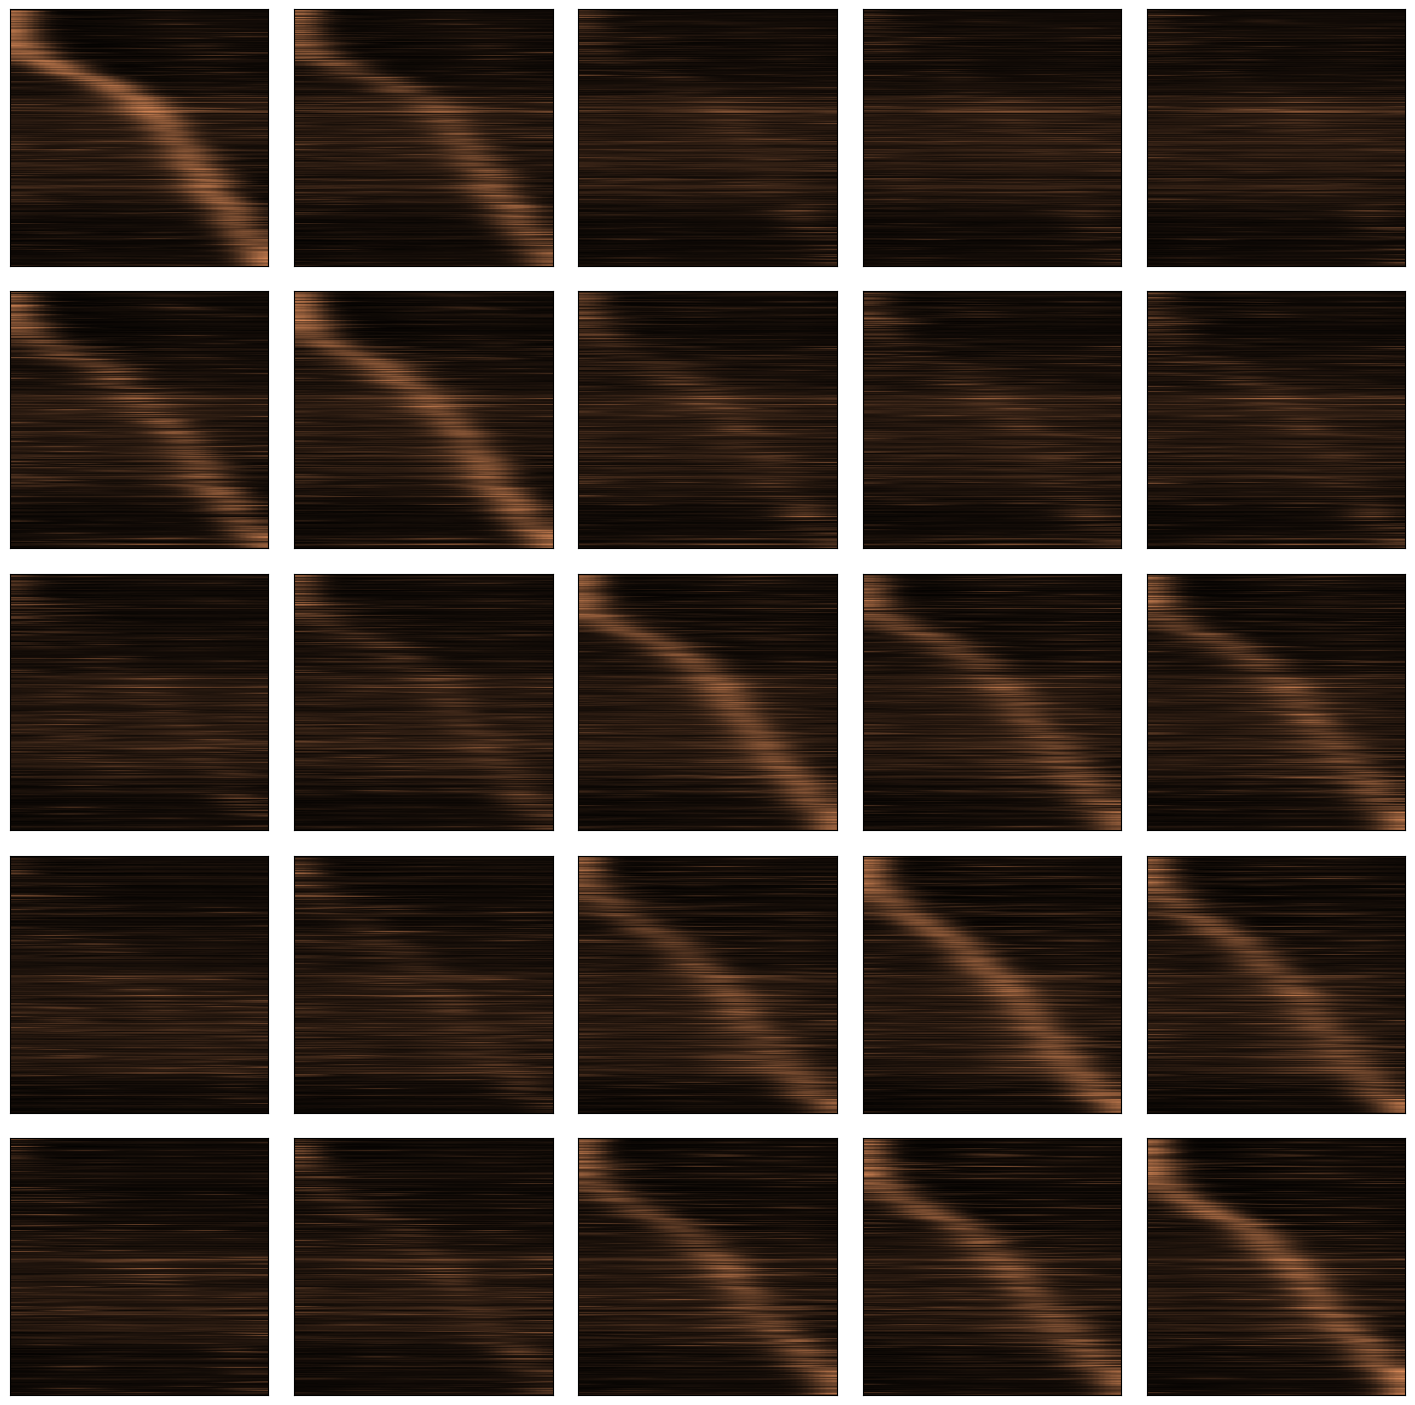

In [233]:
fig, ax = plt.subplots(5,5, figsize=(18,18))

for row, cells in enumerate(main.baseMorphValues):
    for col, trials in enumerate(main.baseMorphValues):
        cellsToPlot = np.transpose(allCellsToPlot[cells][trials][:,np.argsort(np.argmax(allCellsToPlot[cells][cells],axis=0))])
        newNorms = allNorms[row][np.argsort(np.argmax(allCellsToPlot[cells][cells],axis=0))]
        ax[row, col].imshow(figsmooth(cellsToPlot/newNorms.reshape(-1,1),[0,3]),cmap='copper', vmin = 0, vmax=0.9, aspect="auto")
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])
        
plt.subplots_adjust(wspace=0.1, hspace=0.1)        
plt.show()

## Plotting for a SINGLE SESSION

C:\Users\tarek\AppData\Local\Temp\ipykernel_25876\2643713151.py:12: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  A = filters.gaussian_filter(A,sig)
C:\Users\tarek\AppData\Local\Temp\ipykernel_25876\2643713151.py:13: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  One = filters.gaussian_filter(One,sig)


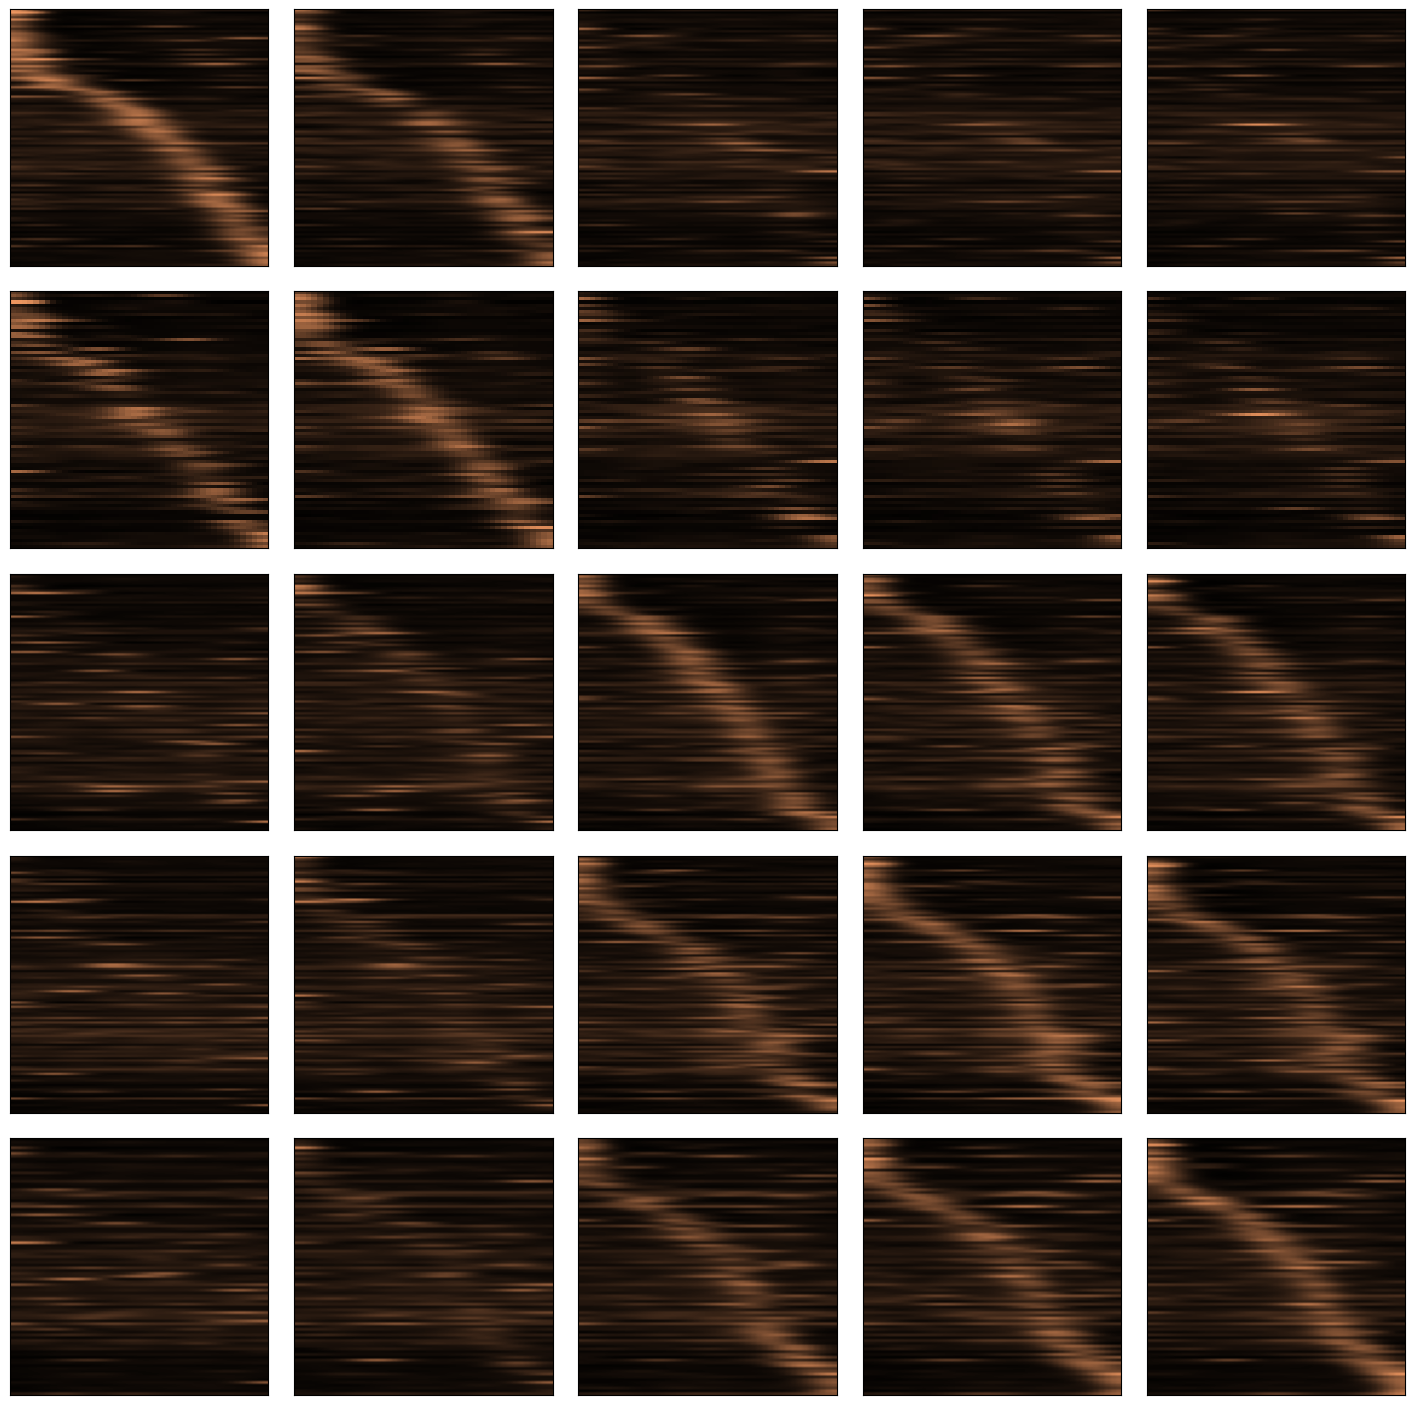

In [117]:
fig, ax = plt.subplots(5,5, figsize=(18,18))

for row, cells in enumerate(main.baseMorphValues):
    for col, trials in enumerate(main.baseMorphValues):
        cellsToPlot = np.transpose(avgActivity[cells][trials][:,np.argsort(np.argmax(avgActivity[cells][cells],axis=0))])
#         newNorms = np.max(cellsToPlot, axis = 1).reshape(-1,1)
#         newNorms = np.max(np.transpose(avgActivity[cells][cells][:,np.argsort(np.argmax(avgActivity[cells][cells],axis=0))]), axis = 1).reshape(-1,1)
        newNorms = norms[row][np.argsort(np.argmax(avgActivity[cells][cells],axis=0))]
        ax[row, col].imshow(figsmooth(cellsToPlot/newNorms.reshape(-1,1),[0,3]),cmap='copper', vmin = 0, vmax=0.9, aspect="auto")
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])
        
plt.subplots_adjust(wspace=0.1, hspace=0.1)        
plt.show()